# K-Means Clustering (Ronde van Vlaanderen)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from math import pi

In [3]:
ronde_dataset = pd.read_csv('../../data/complete_dataset_no_outliers.csv').drop(columns=['profile', 'uci_points', 'mean_cyclist_cp', 'mean_delta', 'mean_position', 'raw_position', 'points'])
ronde_dataset = ronde_dataset[ronde_dataset['race_name'] == 'Ronde van Vlaanderen']
ronde_dataset = ronde_dataset.select_dtypes(include=['number'])
ronde_dataset = ronde_dataset.dropna().reset_index(drop=True)

# drop colums from PCA and UMAP analisis
ronde_dataset = ronde_dataset.drop(['length', 'startlist_quality', 'position', 'delta', 'race_year', 'race_prestige', 'num_participants', 'cyclist_climb_power', 'previous_mean_cp'], axis=1)

ronde_dataset.info()
columns_to_use = ronde_dataset.columns

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(ronde_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   birth_year                   762 non-null    int64  
 1   weight                       762 non-null    float64
 2   height                       762 non-null    float64
 3   climb_total                  762 non-null    float64
 4   cyclist_age                  762 non-null    int64  
 5   cyclist_bmi                  762 non-null    float64
 6   climb_percentage             762 non-null    float64
 7   race_physical_effort         762 non-null    float64
 8   previous_mean_position       762 non-null    float64
 9   previous_mean_delta          762 non-null    float64
 10  cyclist_previous_experience  762 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 65.6 KB


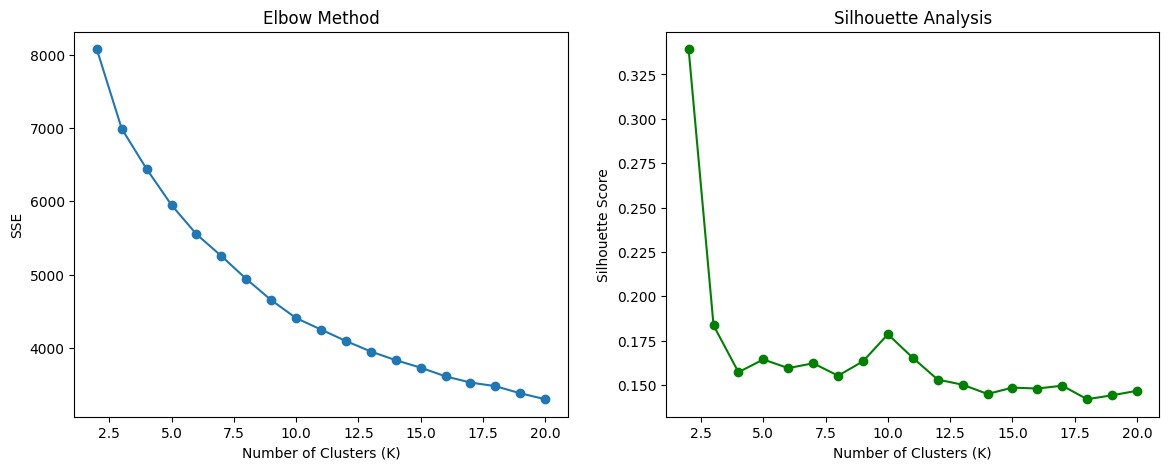

In [12]:
sse_list = []
silhouette_scores = []
max_k = 20

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(data_scaled)
    sse_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Visualizzazione del metodo del gomito
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), sse_list, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.title('Elbow Method')

# Visualizzazione del Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [13]:
# Applicazione del K-Means
n_clusters = 10  # Puoi modificare il numero di cluster
kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=42)
kmeans.fit(data_scaled)

KMeans(max_iter=100, n_clusters=10, n_init=10, random_state=42)

In [14]:
# Etichette dei cluster e centroidi
cluster_labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Aggiunta delle etichette al dataset originale
ronde_dataset['cluster'] = cluster_labels

# Calcolo punteggi di valutazione
print(f"SSE (Sum of Squared Errors): {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_score(data_scaled, cluster_labels)}")


SSE (Sum of Squared Errors): 4405.481107461989
Silhouette Score: 0.17854614495624757


#### 2D Clusters

In [15]:
def plot_variable_pairs(columns_to_use, dataset):
    # Creazione di tutte le combinazioni di coppie di variabili
    pairs = list(itertools.combinations(columns_to_use, 2))
    n_pairs = len(pairs)

    # Dimensione della griglia (calcolata in base al numero di coppie)
    n_cols = 2  # Numero di colonne nella griglia
    n_rows = int(np.ceil(n_pairs / n_cols))  # Numero di righe nella griglia

    # Creazione della griglia di subplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

    # Se c'è una sola riga di subplot, axes sarà un array 1D; uniformiamo la struttura.
    if n_rows == 1:
        axes = axes[np.newaxis, :]

    # Convert columns_to_use to a list
    columns_to_use_list = list(columns_to_use)

    # Plot per ogni coppia di variabili
    for (x_var, y_var), ax in zip(pairs, axes.ravel()):
        sns.scatterplot(
            data=dataset,
            x=x_var, y=y_var, hue="cluster", palette="tab10", ax=ax, s=10
        )
        ax.scatter(
            scaler.inverse_transform(centers)[:, columns_to_use_list.index(x_var)],
            scaler.inverse_transform(centers)[:, columns_to_use_list.index(y_var)],
            s=200, c='red', marker='*', label='Centroids'
        )
        ax.set_title(f'Clusters: {x_var} vs {y_var}')
        ax.legend()

    # Rimuovi subplot vuoti se n_pairs non riempie la griglia
    for ax in axes.ravel()[n_pairs:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

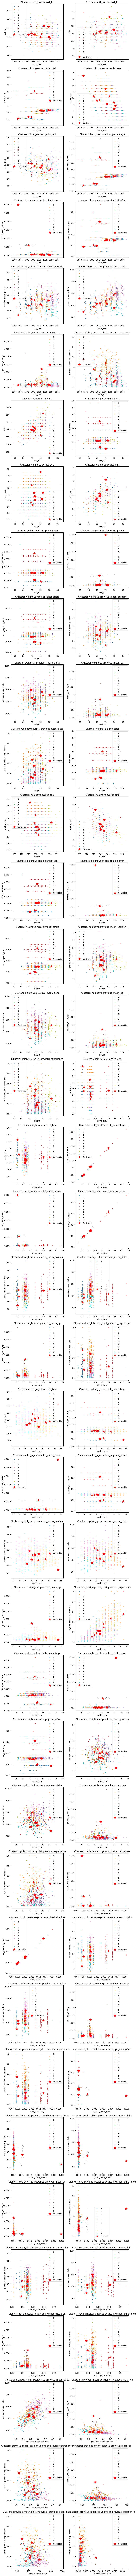

In [16]:
# Esempio di utilizzo della funzione
plot_variable_pairs(columns_to_use, ronde_dataset)

#### 3D Clusters

In [19]:
def plot_variable_triplets(columns_to_use, dataset):
    # Creazione di tutte le combinazioni di triplette di variabili
    triplets = list(itertools.combinations(columns_to_use, 3))
    n_triplets = len(triplets)

    # Dimensione della griglia (calcolata in base al numero di triplette)
    n_cols = 2  # Numero di colonne nella griglia
    n_rows = int(np.ceil(n_triplets / n_cols))  # Numero di righe nella griglia

    # Creazione della griglia di subplot
    fig = plt.figure(figsize=(14, 7 * n_rows))

    # Convert columns_to_use to a list
    columns_to_use_list = list(columns_to_use)

    # Plot per ogni combinazione di tre variabili
    for i, (x_var, y_var, z_var) in enumerate(triplets):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')

        # Scatterplot dei dati
        ax.scatter(
            dataset[x_var],
            dataset[y_var],
            dataset[z_var],
            c=dataset["cluster"], cmap="tab10", s=10, zorder=1
        )

        # Scatterplot dei centroidi
        for center in scaler.inverse_transform(centers):  # Itera su ogni centroide
            ax.scatter(
            center[columns_to_use_list.index(x_var)],
            center[columns_to_use_list.index(y_var)],
            center[columns_to_use_list.index(z_var)],
            s=200, c='red', marker='*', zorder=2
            )

        # Titolo e etichette
        ax.set_title(f'Clusters: {x_var} vs {y_var} vs {z_var}', pad=20)
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
        ax.set_zlabel(z_var)

    # Imposta layout per evitare sovrapposizioni
    plt.tight_layout()
    plt.show()

In [20]:
plot_variable_triplets(columns_to_use, ronde_dataset)

ValueError: Image size of 1400x100100 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x12bbb8220> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1400x100100 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1400x100100 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x100100 with 286 Axes>

#### Last Results

In [ ]:
# Centroidi riportati alle scale originali
centers_original = scaler.inverse_transform(centers)

# Visualizzazione parallela dei centroidi
plt.figure(figsize=(10, 6))
for i in range(len(centers_original)):
    plt.plot(centers_original[i], marker='o', label=f'Cluster {i}')
plt.xticks(range(len(columns_to_use)), columns_to_use, rotation=45)
plt.title('Cluster Centers')
plt.legend()
plt.show()


In [ ]:
N = len(columns_to_use)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Radar Chart per ogni cluster
plt.figure(figsize=(10, 6))
for i, center in enumerate(centers_original):
    values = center.tolist()
    values += values[:1]
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], columns_to_use)
plt.title('Radar Chart for Cluster Centers')
plt.legend()
plt.show()


In [ ]:
# Creazione della griglia basata sulla dimensione di columns_to_use
n_cols = 2  # Numero di colonne nella griglia
n_rows = int(np.ceil(len(columns_to_use) / n_cols))  # Calcola il numero di righe necessarie

# Creazione della griglia di subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

# Se c'è una sola riga di subplot, assicuriamo che `axes` sia un array bidimensionale
if n_rows == 1:
    axes = np.array([axes])

# Loop attraverso le variabili e i subplot
for col, ax in zip(columns_to_use, axes.ravel()):
    # Crea la tabella di contingenza
    cross_df = pd.crosstab(kmeans.labels_, ronde_dataset[col])
    
    # Plot nel subplot corrente
    cross_df.plot(kind='bar', stacked=False, ax=ax, legend=False)
    ax.set_title(f'Distribution per Cluster ({col})')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')

# Rimuove eventuali subplot vuoti (se len(columns_to_use) < n_rows * n_cols)
for ax in axes.ravel()[len(columns_to_use):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()